## AlexNet 实现猫狗大战

## 1、数据准备

在Colab上需要下载数据和准备环境

In [ ]:
!pip install tensorflow
!wget https://github.com/qxdn/DogsVsCats/releases/download/v1.0.0/data.zip
!unzip data.zip
!rm -rf data.zip

AlexNet的输入是`[227,227,3]`，因此要对输入进行预处理，使得符合规范，同时还需要进行贴标签(dog=1,cat=0)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers,models

BATCH_SIZE = 125

def load_image(img_path,size=(227,227)):
    label = tf.constant(0,tf.int8) if tf.strings.regex_full_match(img_path,".*cat.*") \
            else tf.constant(1,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) 
    img = tf.image.resize(img,size)/255.0  #转float要归一
    return(img,label)

In [7]:
#使用并行化预处理num_parallel_calls 和预存数据prefetch来提升性能
# num_parallel_calls=tf.data.experimental.AUTOTUNE 根据CPU动态处理 未指定就顺序处理
#shuffle 随机重排
#batch()一次出多少
#prefetch 提前取出多少批batch
ds_train = tf.data.Dataset.list_files("./data/train/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

ds_test = tf.data.Dataset.list_files("./data/test/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

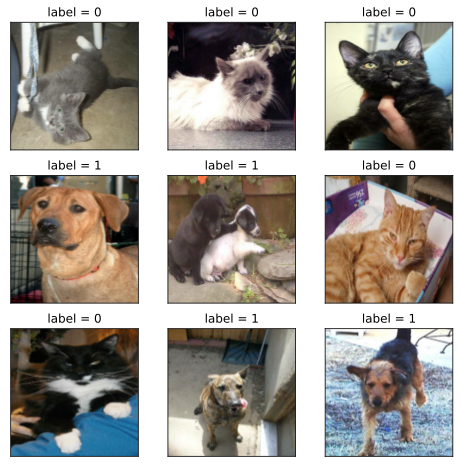

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看训练样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8))  #8*8 inch
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):  #enumerate 组合成索引、数据迭代
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [9]:
for x,y in ds_train.take(1):
    print(x.shape,y.shape)

(125, 227, 227, 3) (125,)


## 2、定义模型
AlexNet相较于以前的网络主要引入了Relu激活函数、DropOut层和lrn局部响应

In [10]:
# LRN层
class LRN(layers.Layer):
    def __init__(self):
        super(LRN, self).__init__()
        self.depth_radius=2
        self.bias=1
        self.alpha=1e-4
        self.beta=0.75
    def call(self,x):
        return tf.nn.lrn(x,depth_radius=self.depth_radius,
                         bias=self.bias,alpha=self.alpha,
                         beta=self.beta)

In [11]:
tf.keras.backend.clear_session() #清空会话

model = models.Sequential()
model.add(layers.Conv2D(96,kernel_size=(11,11),activation='relu',strides=(4,4),input_shape=(227,227,3)))
model.add(layers.MaxPool2D(pool_size=(3, 3),strides=(2,2)))
model.add(LRN())
model.add(layers.Conv2D(256,kernel_size=(5,5),activation='relu',strides=(1,1),padding='same'))
model.add(layers.MaxPool2D(pool_size=(3, 3),strides=(2,2)))
model.add(LRN())
model.add(layers.Conv2D(384,kernel_size=(3,3),activation='relu',strides=(1,1),padding='same'))
model.add(layers.Conv2D(384,kernel_size=(3,3),activation='relu',strides=(1,1),padding='same'))
model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu',strides=(1,1),padding='same'))
model.add(layers.MaxPool2D(pool_size=(3, 3),strides=(2,2)))
model.add(layers.Flatten()) # 不要忘记有一层降为一维
model.add(layers.Dense(4096,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(4096,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(2,activation='softmax'))  #真实的AlexNet会分成1000类，此处分2类 sofmax来计算概率

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
lrn (LRN)                    (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
lrn_1 (LRN)                  (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

## 3、训练模型

In [12]:
import os

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
        loss='sparse_categorical_crossentropy',
        metrics=["accuracy"])

checkpoint_save_path='./checkpoint/AlexNet/AlexNet-{epoch:02d}.ckpt'
#tf生成ckpt文件时会同步生成索引表，那么通过判断是否有索引表，就知道有没有保存过参数。
if os.path.exists(checkpoint_save_path+'.index'):
    print('----------------load the model--------------')
    model.load_weights(checkpoint_save_path)
cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                            save_weights_only=True,
                            save_best_only=True)

history = model.fit(ds_train,epochs= 20,validation_data=ds_test,
                    callbacks = [cp_callback],workers = 4)

Epoch 1/20
184/184 [==============================] - 40s 219ms/step - loss: 0.6630 - accuracy: 0.5944 - val_loss: 0.6141 - val_accuracy: 0.6615
Epoch 2/20
184/184 [==============================] - 40s 220ms/step - loss: 0.5970 - accuracy: 0.6754 - val_loss: 0.5586 - val_accuracy: 0.7040
Epoch 3/20
184/184 [==============================] - 40s 219ms/step - loss: 0.5426 - accuracy: 0.7244 - val_loss: 0.5088 - val_accuracy: 0.7505
Epoch 4/20
184/184 [==============================] - 40s 219ms/step - loss: 0.4946 - accuracy: 0.7598 - val_loss: 0.4840 - val_accuracy: 0.7735
Epoch 5/20
184/184 [==============================] - 40s 220ms/step - loss: 0.4545 - accuracy: 0.7852 - val_loss: 0.4469 - val_accuracy: 0.8055
Epoch 6/20
184/184 [==============================] - 40s 220ms/step - loss: 0.4207 - accuracy: 0.8064 - val_loss: 0.4180 - val_accuracy: 0.8100
Epoch 7/20
184/184 [==============================] - 40s 219ms/step - loss: 0.3991 - accuracy: 0.8193 - val_loss: 0.4016 - val_ac

## 4、评估模型

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

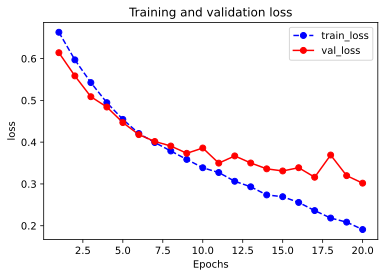

In [14]:
plot_metric(history,"loss") #结果看可以再练练

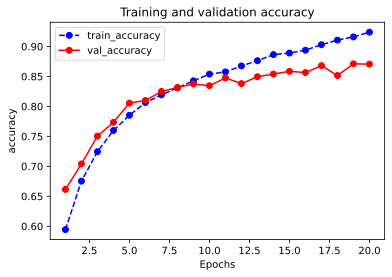

In [15]:
plot_metric(history,"accuracy")

In [16]:
#可以使用evaluate对数据进行评估
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

16/16 [==============================] - 2s 144ms/step - loss: 0.3019 - accuracy: 0.8705
0.3018629252910614 0.8705000281333923


## 5、使用模型

In [26]:
def perpareImage(img,sizes=(-1,227,227,3)):
  img = tf.reshape(img,shape=sizes)
  return img

In [66]:
for i,(img,label) in enumerate(ds_test.unbatch().take(1)):
  img=tf.reshape(img,shape=(-1,227,227,3))
  p=model.predict(img)
  print(p)
  p=tf.argmax(p,1)
  print(p)
  print(p.shape)

[[0.91607434 0.08392565]]
tf.Tensor([0], shape=(1,), dtype=int64)
(1,)


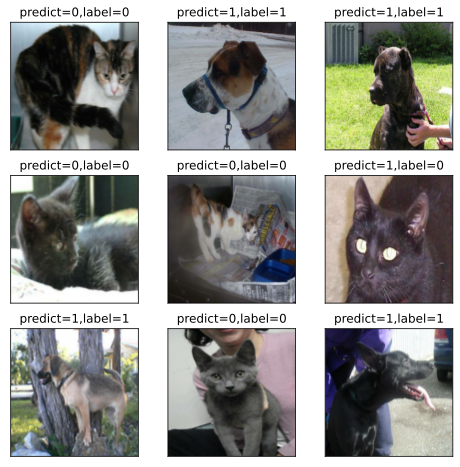

In [69]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看训练样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8))  #8*8 inch
for i,(img,label) in enumerate(ds_test.unbatch().take(9)):  #enumerate 组合成索引、数据迭代
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    predict = model.predict(perpareImage(img))
    ax.set_title("predict=%d,label=%d"%(tf.argmax(predict,1),label))
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

## 6、保存模型
tensorflow原生保存

In [70]:
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署

model.save('./model/tf_AlexNet_Model', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./model/tf_AlexNet_Model')
model_loaded.evaluate(ds_test)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/tf_AlexNet_Model/assets
export saved model.
16/16 [==============================] - 2s 147ms/step - loss: 0.3019 - accuracy: 0.5155


[0.301862895488739, 0.515500009059906]